In [18]:
from pyspark.sql.types import *
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local) created by __init__ at /var/folders/z7/8n2dlxg16tggjrtnz6s70x180000gn/T/ipykernel_22073/2786543603.py:4 

In [3]:
# https://www.kaggle.com/datasets/edumagalhaes/quality-prediction-in-a-mining-process?resource=download

In [2]:
df = spark.read.load('/Users/olenapleshan/data_analytics/ca3/MiningProcess_Flotation_Plant_Database.csv',  format="csv", header="true", sep=',')

#df = spark.read.load('/Users/olenapleshan/data_analytics/ca3/MiningProcess_Flotation_Plant_Database.csv', format="csv", header="true", sep=',', schema=customSchema)
df.printSchema()

root
 |-- date: string (nullable = true)
 |-- % Iron Feed: string (nullable = true)
 |-- % Silica Feed: string (nullable = true)
 |-- Starch Flow: string (nullable = true)
 |-- Amina Flow: string (nullable = true)
 |-- Ore Pulp Flow: string (nullable = true)
 |-- Ore Pulp pH: string (nullable = true)
 |-- Ore Pulp Density: string (nullable = true)
 |-- Flotation Column 01 Air Flow: string (nullable = true)
 |-- Flotation Column 02 Air Flow: string (nullable = true)
 |-- Flotation Column 03 Air Flow: string (nullable = true)
 |-- Flotation Column 04 Air Flow: string (nullable = true)
 |-- Flotation Column 05 Air Flow: string (nullable = true)
 |-- Flotation Column 06 Air Flow: string (nullable = true)
 |-- Flotation Column 07 Air Flow: string (nullable = true)
 |-- Flotation Column 01 Level: string (nullable = true)
 |-- Flotation Column 02 Level: string (nullable = true)
 |-- Flotation Column 03 Level: string (nullable = true)
 |-- Flotation Column 04 Level: string (nullable = true)
 |

In [3]:
#Create first network with Keras
import numpy
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, Conv1D, Input

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from tensorflow.python.keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score


2024-09-11 20:20:39.214960: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# for local development outside of Spark, we can convert this into pandas
dataset = df.toPandas()
dataset.head()

,date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
0,2017-03-10 01:00:00,"55,2","16,98","3019,53","557,434","395,713","10,0664","1,74","249,214","253,235",...,"250,884","457,396","432,962","424,954","443,558","502,255","446,37","523,344","66,91","1,31"
1,2017-03-10 01:00:00,"55,2","16,98","3024,41","563,965","397,383","10,0672","1,74","249,719","250,532",...,"248,994","451,891","429,56","432,939","448,086","496,363","445,922","498,075","66,91","1,31"
2,2017-03-10 01:00:00,"55,2","16,98","3043,46","568,054","399,668","10,068","1,74","249,741","247,874",...,"248,071","451,24","468,927","434,61","449,688","484,411","447,826","458,567","66,91","1,31"
3,2017-03-10 01:00:00,"55,2","16,98","3047,36","568,665","397,939","10,0689","1,74","249,917","254,487",...,"251,147","452,441","458,165","442,865","446,21","471,411","437,69","427,669","66,91","1,31"
4,2017-03-10 01:00:00,"55,2","16,98","3033,69","558,167","400,254","10,0697","1,74","250,203","252,136",...,"248,928","452,441","452,9","450,523","453,67","462,598","443,682","425,679","66,91","1,31"


In [5]:
dataset = dataset.rename(columns={c: c.lower().replace(" ", "_").replace("%", "pct") for c in dataset.columns})

In [6]:
dataset.columns

Index(['date', 'pct_iron_feed', 'pct_silica_feed', 'starch_flow', 'amina_flow',
       'ore_pulp_flow', 'ore_pulp_ph', 'ore_pulp_density',
       'flotation_column_01_air_flow', 'flotation_column_02_air_flow',
       'flotation_column_03_air_flow', 'flotation_column_04_air_flow',
       'flotation_column_05_air_flow', 'flotation_column_06_air_flow',
       'flotation_column_07_air_flow', 'flotation_column_01_level',
       'flotation_column_02_level', 'flotation_column_03_level',
       'flotation_column_04_level', 'flotation_column_05_level',
       'flotation_column_06_level', 'flotation_column_07_level',
       'pct_iron_concentrate', 'pct_silica_concentrate'],
      dtype='object')

In [7]:
dataset = dataset.replace(",", ".", regex=True)
dataset.head()

,date,pct_iron_feed,pct_silica_feed,starch_flow,amina_flow,ore_pulp_flow,ore_pulp_ph,ore_pulp_density,flotation_column_01_air_flow,flotation_column_02_air_flow,...,flotation_column_07_air_flow,flotation_column_01_level,flotation_column_02_level,flotation_column_03_level,flotation_column_04_level,flotation_column_05_level,flotation_column_06_level,flotation_column_07_level,pct_iron_concentrate,pct_silica_concentrate
0,2017-03-10 01:00:00,55.2,16.98,3019.53,557.434,395.713,10.0664,1.74,249.214,253.235,...,250.884,457.396,432.962,424.954,443.558,502.255,446.37,523.344,66.91,1.31
1,2017-03-10 01:00:00,55.2,16.98,3024.41,563.965,397.383,10.0672,1.74,249.719,250.532,...,248.994,451.891,429.56,432.939,448.086,496.363,445.922,498.075,66.91,1.31
2,2017-03-10 01:00:00,55.2,16.98,3043.46,568.054,399.668,10.068,1.74,249.741,247.874,...,248.071,451.24,468.927,434.61,449.688,484.411,447.826,458.567,66.91,1.31
3,2017-03-10 01:00:00,55.2,16.98,3047.36,568.665,397.939,10.0689,1.74,249.917,254.487,...,251.147,452.441,458.165,442.865,446.21,471.411,437.69,427.669,66.91,1.31
4,2017-03-10 01:00:00,55.2,16.98,3033.69,558.167,400.254,10.0697,1.74,250.203,252.136,...,248.928,452.441,452.9,450.523,453.67,462.598,443.682,425.679,66.91,1.31


In [8]:
dataset.to_csv("Cleaned_MiningProcess_Flotation_Plant_Database.csv", index=False)

In [9]:
dataset = dataset.sample(n=1000)

In [10]:
# split into input (X ie dependent variables) and output (Y ie independent variables) variables

X = dataset.iloc[:,1:23]   # drop the date, columns 1-22 are independent variables
Y = dataset.iloc[:,23] # % Silica Concentrate

X.shape
Y = Y.astype(float)

In [11]:
X.shape
Y = Y.astype(float)

In [12]:
Y

444267    1.30
83192     1.68
603596    1.41
231907    1.82
272770    1.21
          ... 
350260    1.82
233383    1.14
452104    1.43
258349    0.85
10230     2.99
Name: pct_silica_concentrate, Length: 1000, dtype: float64

In [13]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [14]:
# create model
model = Sequential()
model.add(Dense(500, input_dim=X.shape[1], activation='sigmoid')) # 500 neurons
model.add(Dense(1)) # 1 output neuron

model.compile(loss='mean_squared_error', optimizer='adagrad', metrics=[keras.metrics.RootMeanSquaredError(), 
                                keras.metrics.MeanAbsoluteError(),
                                keras.metrics.Accuracy()])


In [15]:
# Compile model
h = model.fit(X, Y, epochs=50, batch_size=20,  verbose=2) # 150 epoch, 10 batch size, verbose = 2

Epoch 1/50
50/50 - 1s - loss: 2.3518 - root_mean_squared_error: 1.5336 - mean_absolute_error: 1.1164 - accuracy: 0.0000e+00 - 1s/epoch - 22ms/step
Epoch 2/50
50/50 - 0s - loss: 1.3277 - root_mean_squared_error: 1.1522 - mean_absolute_error: 0.9205 - accuracy: 0.0000e+00 - 220ms/epoch - 4ms/step
Epoch 3/50
50/50 - 0s - loss: 1.2344 - root_mean_squared_error: 1.1110 - mean_absolute_error: 0.9119 - accuracy: 0.0000e+00 - 120ms/epoch - 2ms/step
Epoch 4/50
50/50 - 0s - loss: 1.1737 - root_mean_squared_error: 1.0834 - mean_absolute_error: 0.8866 - accuracy: 0.0000e+00 - 91ms/epoch - 2ms/step
Epoch 5/50
50/50 - 0s - loss: 1.1224 - root_mean_squared_error: 1.0594 - mean_absolute_error: 0.8650 - accuracy: 0.0000e+00 - 81ms/epoch - 2ms/step
Epoch 6/50
50/50 - 0s - loss: 1.0804 - root_mean_squared_error: 1.0394 - mean_absolute_error: 0.8502 - accuracy: 0.0000e+00 - 85ms/epoch - 2ms/step
Epoch 7/50
50/50 - 0s - loss: 1.0431 - root_mean_squared_error: 1.0213 - mean_absolute_error: 0.8273 - accuracy

In [19]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_metrics(history):
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    #Add traces
    for k, v in history.history.items():
        fig.add_trace(
            go.Scatter( y=v, name=k),
            secondary_y=False,
        )

    # Add figure title
    fig.update_layout(
        title_text="Loss/Accuracy of LSTM Model"
    )
    
    # Set x-axis title
    fig.update_xaxes(title_text="Epoch")
    # Set y-axes titles
    fig.update_yaxes(title_text="<b>primary</b> Loss", secondary_y=False)
    fig.update_yaxes(title_text="<b>secondary</b> MAE", secondary_y=True)
    
    fig.show()

In [20]:
plot_metrics(h)

In [21]:
# evaluate the model
scores = model.evaluate(X, Y)
print(scores)

predictions = model.predict(X)    # predicting Y only using X


32/32 [==============================] - 0s 7ms/step - loss: 0.5968 - root_mean_squared_error: 0.7725 - mean_absolute_error: 0.6013 - accuracy: 0.0000e+00
[0.5967673063278198, 0.7725071310997009, 0.6013301014900208, 0.0]
32/32 [==============================] - 0s 2ms/step


In [22]:
# calculate predictions
predictions = model.predict(X)    # predicting Y only using X

32/32 [==============================] - 0s 2ms/step


In [23]:
# Round predictions
#rounded = [int(numpy.round(x, 0)) for x in predictions]
rounded = [round(x[0]) for x in predictions]
print(rounded)

[2, 2, 3, 3, 2, 2, 3, 3, 2, 4, 2, 2, 2, 4, 2, 2, 2, 2, 3, 2, 3, 3, 3, 1, 3, 3, 2, 2, 2, 1, 2, 2, 3, 3, 2, 2, 3, 2, 4, 3, 2, 1, 3, 4, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 2, 4, 2, 2, 2, 3, 1, 4, 2, 2, 3, 3, 2, 2, 3, 2, 2, 3, 3, 2, 1, 2, 2, 2, 3, 3, 2, 3, 3, 3, 4, 2, 2, 2, 3, 2, 2, 4, 2, 2, 3, 3, 2, 2, 2, 4, 1, 3, 2, 3, 2, 2, 2, 4, 2, 2, 2, 3, 3, 2, 2, 3, 4, 3, 2, 2, 2, 2, 2, 2, 3, 4, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 1, 1, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 3, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 2, 2, 3, 1, 3, 2, 4, 3, 2, 3, 2, 2, 3, 1, 2, 3, 2, 1, 3, 1, 2, 2, 1, 2, 3, 2, 2, 3, 3, 4, 2, 3, 2, 1, 3, 2, 3, 2, 2, 3, 3, 2, 3, 2, 2, 2, 2, 3, 2, 3, 3, 2, 3, 2, 3, 2, 3, 2, 1, 2, 3, 2, 3, 2, 2, 2, 2, 4, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 2, 2, 2, 3, 1, 2, 2, 2, 2, 2, 1, 1, 2, 3, 3, 3, 2, 3, 2, 2, 2, 3, 3, 3, 2, 3, 3, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 

In [18]:
# FOR CLASSIFICATION
# import matplotlib.pyplot as plt
# import numpy
# from sklearn import metrics

# actual = Y
# predicted = rounded

# confusion_matrix = metrics.confusion_matrix(actual, predicted)

# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

# cm_display.plot()
# plt.show() 

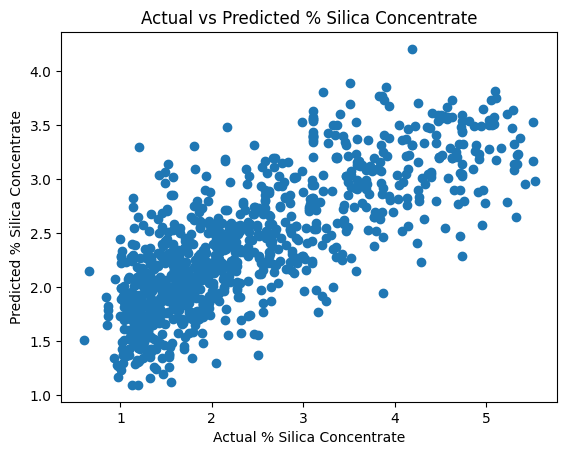

In [24]:
plt.scatter(Y, predictions)
plt.xlabel('Actual % Silica Concentrate')
plt.ylabel('Predicted % Silica Concentrate')
plt.title('Actual vs Predicted % Silica Concentrate')
plt.show()

A residual is a measure of how far away a point is vertically from the regression line. Simply, it is the error between a predicted value and the observed actual value.

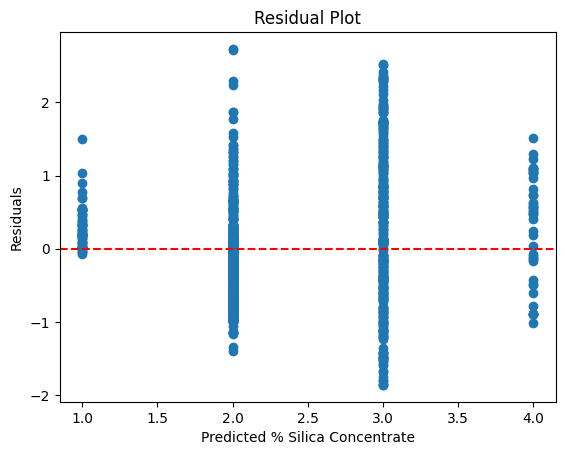

In [25]:
residuals = Y - rounded
plt.scatter(rounded, residuals)
plt.xlabel('Predicted % Silica Concentrate')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Prepare for experimentation

In this section, we will create a function which will allow to run multiple experiments with different inputs without copy-pasting the code

In [29]:
class Experiment:
    x=X
    y=Y

    dense_units=500
    epocs=50
    validation_split=0.2
    activation='sigmoid'
    loss='mean_squared_error'
    optimizer='adagrad'
    
    model=None
    history=None
    predictions=None


    def __init__(self):
        pass

    def build_ann(self):
        model = Sequential()
        # Dense: fully connected layer in a sequential mode
        # implementation of the equation output = activation(dot(input, kernel) + bias)
        model.add(Dense(self.dense_units,        # number of neurons
                         input_dim=self.x.shape[1], 
                         activation=self.activation))
         
        model.add(Dense(1))                      # 1 output neuron
         
        model.compile(loss=self.loss, 
                       optimizer=self.optimizer,
                       metrics=[keras.metrics.RootMeanSquaredError(), 
                                keras.metrics.MeanAbsoluteError(),
                                keras.metrics.Accuracy()])
        
        self.model = model
    
    def fit_and_predict(self):
        self.history = self.model.fit(self.x, self.y, 
                                 validation_split=self.validation_split, 
                                 epochs=self.epocs, 
                                 batch_size=20,  
                                 verbose=0)
        
        self.predictions = self.model.predict(self.x)    # predicting Y only using X
    
    def plot_prediction(self):
        plt.scatter(self.y, self.predictions)
        plt.xlabel('Actual % Silica Concentrate')
        plt.ylabel('Predicted % Silica Concentrate')
        plt.title(f'Activation func: {self.activation}, optimizer: {self.optimizer}, dense units: {self.dense_units}, epocs: {self.epocs}')
        plt.show()


# ANN
Artificial Neural Network 

32/32 [==============================] - 0s 3ms/step


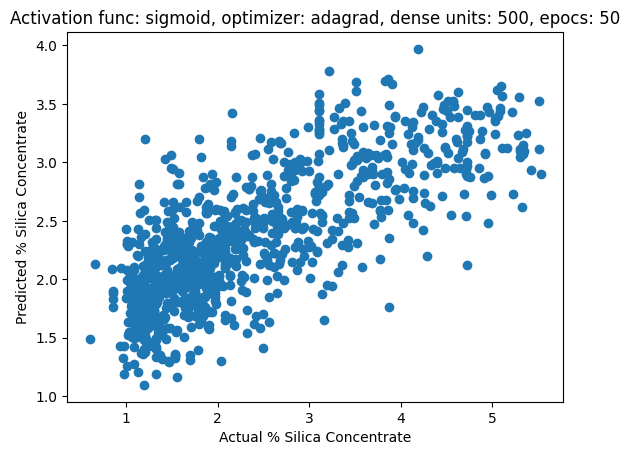

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 500)               11500     
                                                                 
 dense_7 (Dense)             (None, 1)                 501       
                                                                 
Total params: 12001 (46.88 KB)
Trainable params: 12001 (46.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
32/32 [==============================] - 0s 3ms/step - loss: 0.6438 - root_mean_squared_error: 0.8024 - mean_absolute_error: 0.6268 - accuracy: 0.0000e+00


In [30]:
# create model
experiment1 = Experiment()
experiment1.build_ann()
experiment1.fit_and_predict()
experiment1.plot_prediction()

experiment1.model.summary(),
experiment1.model.evaluate(X, Y)

plot_metrics(experiment1.history)


## Experiments

## Experiments with Activation Functions

32/32 [==============================] - 0s 1ms/step


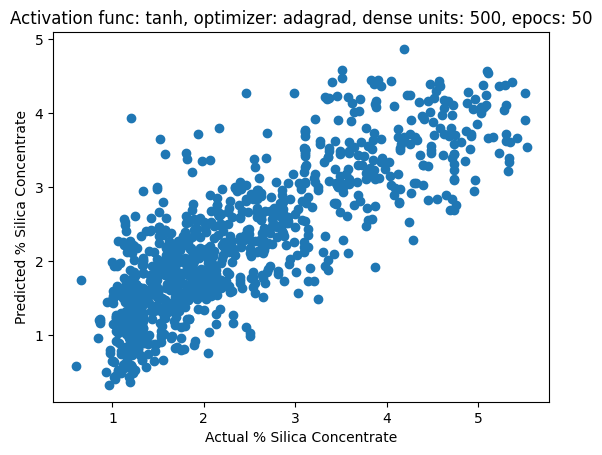

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 500)               11500     
                                                                 
 dense_9 (Dense)             (None, 1)                 501       
                                                                 
Total params: 12001 (46.88 KB)
Trainable params: 12001 (46.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
32/32 [==============================] - 0s 3ms/step - loss: 0.4402 - root_mean_squared_error: 0.6635 - mean_absolute_error: 0.5067 - accuracy: 0.0000e+00


In [31]:
experiment2 = Experiment()
experiment2.activation='tanh'

experiment2.build_ann()
experiment2.fit_and_predict()
experiment2.plot_prediction()

experiment2.model.summary(),
experiment2.model.evaluate(X, Y)

plot_metrics(experiment2.history)


32/32 [==============================] - 0s 1ms/step


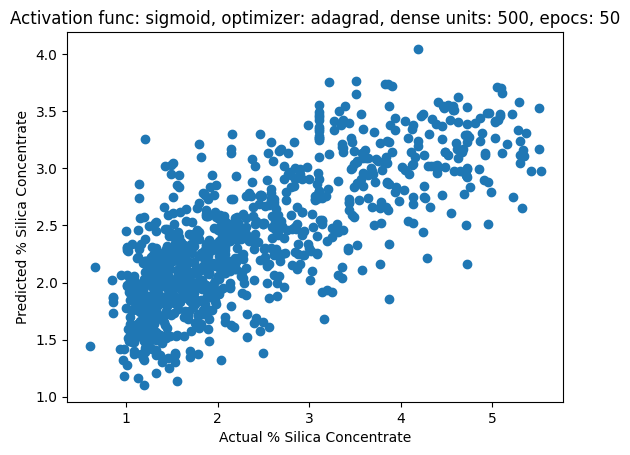

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 500)               11500     
                                                                 
 dense_11 (Dense)            (None, 1)                 501       
                                                                 
Total params: 12001 (46.88 KB)
Trainable params: 12001 (46.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
32/32 [==============================] - 0s 3ms/step - loss: 0.6256 - root_mean_squared_error: 0.7909 - mean_absolute_error: 0.6175 - accuracy: 0.0000e+00


In [32]:
experiment3 = Experiment()
experiment3.activation='sigmoid'

experiment3.build_ann()
experiment3.fit_and_predict()
experiment3.plot_prediction()

experiment3.model.summary(),
experiment3.model.evaluate(X, Y)

plot_metrics(experiment3.history)


32/32 [==============================] - 0s 2ms/step


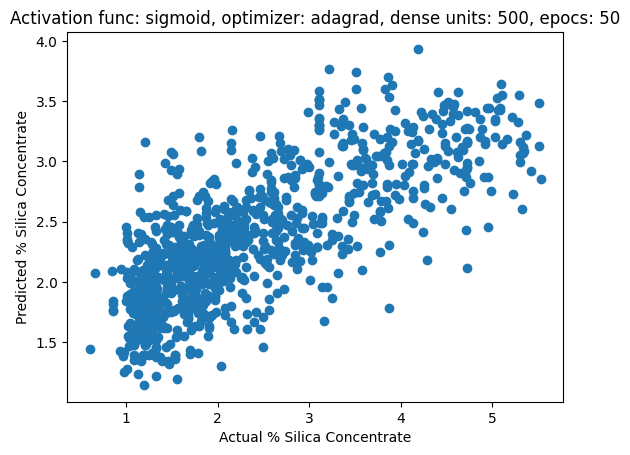

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 500)               11500     
                                                                 
 dense_13 (Dense)            (None, 1)                 501       
                                                                 
Total params: 12001 (46.88 KB)
Trainable params: 12001 (46.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
32/32 [==============================] - 0s 2ms/step - loss: 0.6481 - root_mean_squared_error: 0.8050 - mean_absolute_error: 0.6287 - accuracy: 0.0000e+00


In [33]:
experiment4 = Experiment()
experiment4.activation='sigmoid'
experiment4.optimizer='adagrad'

experiment4.build_ann()
experiment4.fit_and_predict()
experiment4.plot_prediction()

experiment4.model.summary(),
experiment4.model.evaluate(X, Y)

plot_metrics(experiment4.history)

32/32 [==============================] - 0s 1ms/step


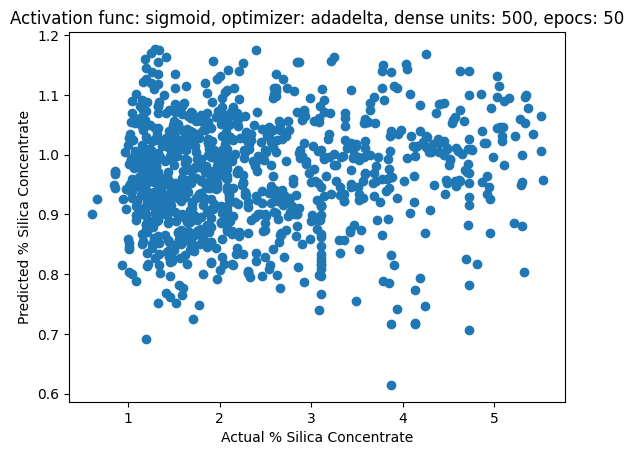

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 500)               11500     
                                                                 
 dense_15 (Dense)            (None, 1)                 501       
                                                                 
Total params: 12001 (46.88 KB)
Trainable params: 12001 (46.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
32/32 [==============================] - 0s 1ms/step - loss: 3.2177 - root_mean_squared_error: 1.7938 - mean_absolute_error: 1.3958 - accuracy: 0.0000e+00


In [34]:
experiment5 = Experiment()
experiment5.activation='sigmoid'
experiment5.optimizer='adadelta'

experiment5.build_ann()
experiment5.fit_and_predict()
experiment5.plot_prediction()

experiment5.model.summary(),
experiment5.model.evaluate(X, Y)

plot_metrics(experiment5.history)

32/32 [==============================] - 0s 2ms/step


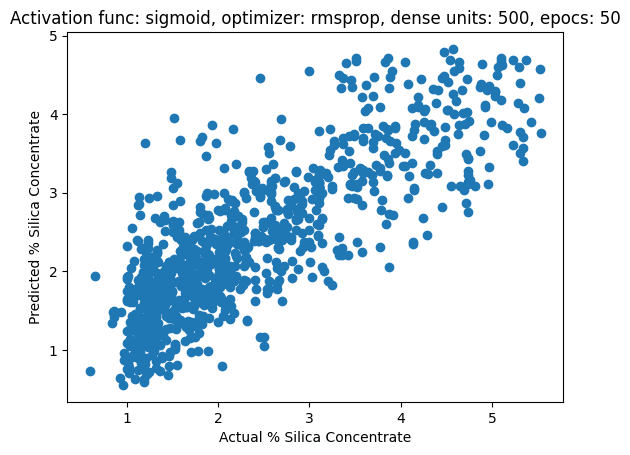

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 500)               11500     
                                                                 
 dense_17 (Dense)            (None, 1)                 501       
                                                                 
Total params: 12001 (46.88 KB)
Trainable params: 12001 (46.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
32/32 [==============================] - 0s 3ms/step - loss: 0.4413 - root_mean_squared_error: 0.6643 - mean_absolute_error: 0.5069 - accuracy: 0.0000e+00


In [35]:
experiment6 = Experiment()
experiment6.activation='sigmoid'
experiment6.optimizer='rmsprop'

experiment6.build_ann()
experiment6.fit_and_predict()
experiment6.plot_prediction()

experiment6.model.summary(),
experiment6.model.evaluate(X, Y)

plot_metrics(experiment6.history)

32/32 [==============================] - 0s 8ms/step


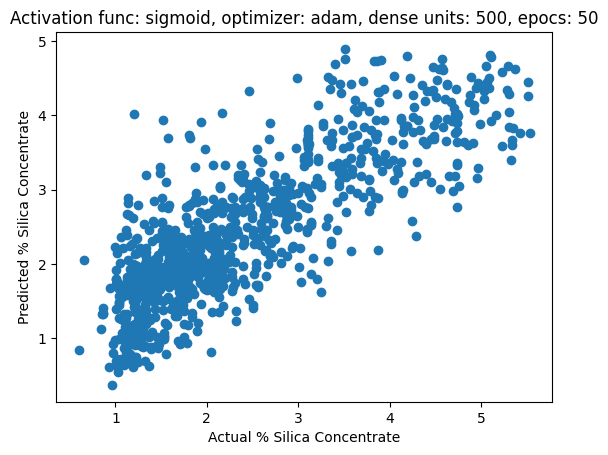

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 500)               11500     
                                                                 
 dense_19 (Dense)            (None, 1)                 501       
                                                                 
Total params: 12001 (46.88 KB)
Trainable params: 12001 (46.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
32/32 [==============================] - 0s 2ms/step - loss: 0.4177 - root_mean_squared_error: 0.6463 - mean_absolute_error: 0.4991 - accuracy: 0.0000e+00


In [36]:
experiment7 = Experiment()
experiment7.activation='sigmoid'
experiment7.optimizer='adam'

experiment7.build_ann()
experiment7.fit_and_predict()
experiment7.plot_prediction()

experiment7.model.summary(),
experiment7.model.evaluate(X, Y)

plot_metrics(experiment7.history)

32/32 [==============================] - 0s 1ms/step


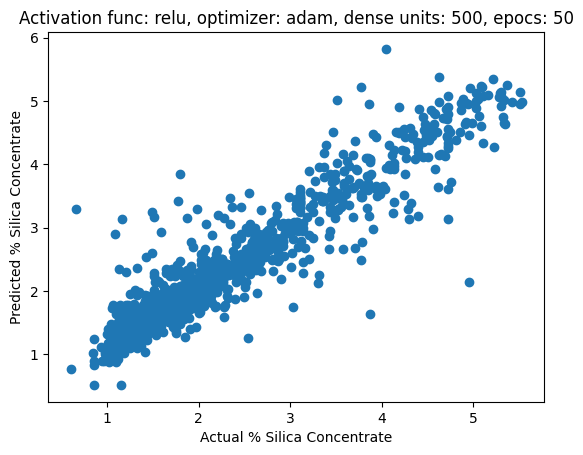

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 500)               11500     
                                                                 
 dense_23 (Dense)            (None, 1)                 501       
                                                                 
Total params: 12001 (46.88 KB)
Trainable params: 12001 (46.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
32/32 [==============================] - 0s 3ms/step - loss: 0.1655 - root_mean_squared_error: 0.4068 - mean_absolute_error: 0.2673 - accuracy: 0.0000e+00


In [38]:
experiment8 = Experiment()
experiment8.activation='relu'
experiment8.optimizer='adam'

experiment8.build_ann()
experiment8.fit_and_predict()
experiment8.plot_prediction()

experiment8.model.summary(),
experiment8.model.evaluate(X, Y)

plot_metrics(experiment8.history)

32/32 [==============================] - 0s 4ms/step


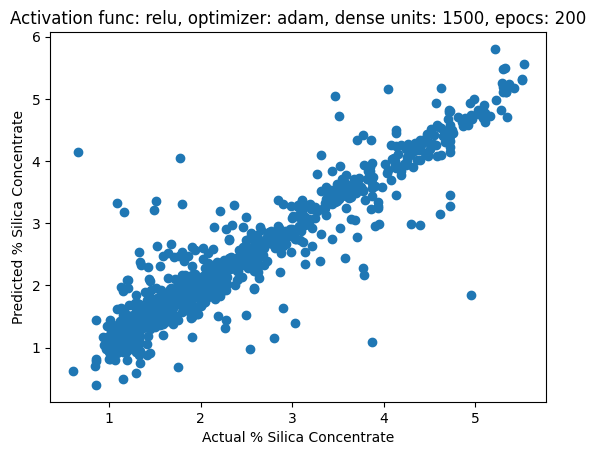

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 1500)              34500     
                                                                 
 dense_27 (Dense)            (None, 1)                 1501      
                                                                 
Total params: 36001 (140.63 KB)
Trainable params: 36001 (140.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
32/32 [==============================] - 0s 3ms/step - loss: 0.1573 - root_mean_squared_error: 0.3967 - mean_absolute_error: 0.2331 - accuracy: 0.0000e+00


In [40]:
experiment9 = Experiment()
experiment9.activation='relu'
experiment9.optimizer='adam'
experiment9.epocs=200
experiment9.dense_units=1500

experiment9.build_ann()
experiment9.fit_and_predict()
experiment9.plot_prediction()

experiment9.model.summary(),
experiment9.model.evaluate(X, Y)

plot_metrics(experiment9.history)

# SCRAP CODE

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# def plot_history(history):
#   plt.figure()
#   plt.xlabel('Epoch')
#   plt.ylabel('Mean Abs Error [1000$]')
#   plt.plot(history.epoch, np.array(history.history['mae']), 
#            label='Train')
#   plt.plot(history.epoch, np.array(history.history['val_mae']),
#            label = 'Val')
#   plt.legend()
#   plt.ylim([0,max(history.history['val_mae'])])


# def plot_prediction(test_labels, test_predictions):
#   plt.figure()
#   plt.scatter(test_labels, test_predictions)
#   plt.xlabel('True Values [1000$]')
#   plt.ylabel('Predictions [1000$]')
#   plt.axis('equal')
#   plt.xlim(plt.xlim())
#   plt.ylim(plt.ylim())
#   _ = plt.plot([-100, 100],[-100,100])

#   plt.figure()
#   error = test_predictions - test_labels
#   plt.hist(error, bins = 50)
#   plt.xlabel("Prediction Error [1000$]")
#   _ = plt.ylabel("Count")

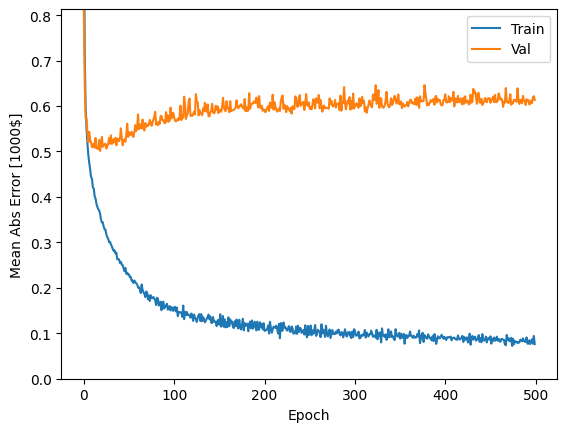

In [56]:
plot_history(history)

In [ ]:
[loss, mae] = model.evaluate(test_data, test_labels, verbose=0)
print("Testing set Mean Abs Error: ${:7.2f}".format(mae * 1000))

### Saving the Model

## Recurring Neural Networks

https://keras.io/api/layers/recurrent_layers/lstm/

In [115]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

In [120]:
@classmethod
def build_rnn(self):
    rnn = Sequential()
    # Long Short-Term Memory layer
    rnn.add(LSTM(units = 45, return_sequences = True, input_shape = (self.x.shape[1], 1)))
    rnn.add(Dropout(0.2))
    
    rnn.add(LSTM(units = 45, return_sequences = True))
    rnn.add(Dropout(0.2))
    
    rnn.add(LSTM(units = 45, return_sequences = True))
    rnn.add(Dropout(0.2))
    
    rnn.add(LSTM(units = 45))
    rnn.add(Dropout(0.2))
    
    rnn.add(Dense(units = 1))
    
    rnn.compile(optimizer = self.optimizer, 
                loss = self.loss,
                metrics=[keras.metrics.RootMeanSquaredError(), 
                               keras.metrics.MeanAbsoluteError(),
                               keras.metrics.Accuracy()])
    self.rnn_model = rnn

Experiment.build_rnn = build_rnn


In [132]:
history = rnn.fit(X, Y, epochs = 100, validation_split=0.2, batch_size = 32)

Epoch 1/100
 1/25 [>.............................] - ETA: 1s - loss: 0.4585 - root_mean_squared_error: 0.6771 - mean_absolute_error: 0.5339 - accuracy: 0.0000e+00

25/25 [==============================] - 1s 51ms/step - loss: 0.4263 - root_mean_squared_error: 0.6529 - mean_absolute_error: 0.4947 - accuracy: 0.0000e+00 - val_loss: 0.4339 - val_root_mean_squared_error: 0.6587 - val_mean_absolute_error: 0.5116 - val_accuracy: 0.0000e+00
Epoch 2/100
25/25 [==============================] - 1s 37ms/step - loss: 0.4252 - root_mean_squared_error: 0.6521 - mean_absolute_error: 0.5034 - accuracy: 0.0000e+00 - val_loss: 0.4512 - val_root_mean_squared_error: 0.6717 - val_mean_absolute_error: 0.5141 - val_accuracy: 0.0000e+00
Epoch 3/100
25/25 [==============================] - 1s 37ms/step - loss: 0.4049 - root_mean_squared_error: 0.6363 - mean_absolute_error: 0.4882 - accuracy: 0.0000e+00 - val_loss: 0.4438 - val_root_mean_squared_error: 0.6662 - val_mean_absolute_error: 0.5043 - val_accuracy: 0.0000e+00
Epoch 4/100
25/25 [==============================] - 1s 37ms/step - loss: 0.4474 - root_mean_squared_error: 0.6689 - mean_absolute_error: 0.5001 - accurac

32/32 [==============================] - 3s 15ms/step


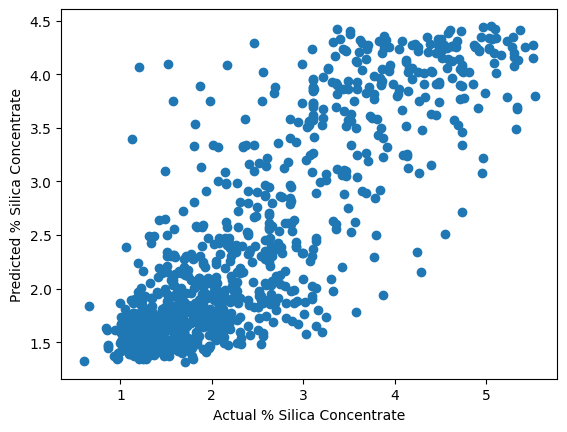

In [131]:
predictions = rnn.predict(X)    # predicting Y only using X

plt.scatter(Y, predictions)
plt.xlabel('Actual % Silica Concentrate')
plt.ylabel('Predicted % Silica Concentrate')
plt.show()